Parâmetros iniciais do caderno notebook

In [1]:
base_path = 'D:/'
#base_path = '/content/drive/My Drive/Colab Notebooks/'


Importando as bibliotecas


In [9]:

import pandas as pd
import time
import pytz
from datetime import datetime
import os
import csv
import requests, zipfile
from xml.etree import ElementTree
import re

class Main:     
    def show_current_time(self):
        ini = time.time()
        tz_SP = pytz.timezone('America/Sao_Paulo') 
        now = datetime.now(tz_SP)
        current_time = now.strftime("%d/%m/%Y %H:%M:%S")
        print("Current Time =", current_time)  
        

print("Versão dopandas: " + pd.__version__)  
  

Versão dopandas: 1.0.5


Gerando arquivos .CSV

In [14]:
ano = '2019'
meses = ['01','02','03','04','05','06','07','08','09','10','11','12']
#meses=[]
#print(meses)
secoes= ['01','02','03']
#print(secoes)




contador = 0

def setaTargetComValor(texto):
    
    x = re.search("""(altera|alterar|alteração)\s*(da|de|do)?\s*(estrutura|organograma|funcional)?
                  \s*(da|de|do)?\s*(organização|organizacional|regimental|ministério|governo|secretaria
                  |unidade|estrutura|organograma|funcional)
                  """, 
                  texto, re.IGNORECASE |  re.MULTILINE | re.X)
    y = re.search("""(disp[oõ]e)\s*(sobre)?\s*a?\s*(estrutura|funcionamento|competência)""", 
                  texto, re.IGNORECASE |  re.MULTILINE | re.X)
    z = re.search("""(criação|extinção|criar|extinguir)
                .*(organização|organizacional|regimental|ministério|governo|secretaria
                  |unidade|estrutura|organograma|funcional|estrutura|organograma|funcional)""", 
                  texto, re.IGNORECASE |  re.MULTILINE | re.X)
    w = re.search("""(organização|organizacional|regimental|ministério|governo|secretaria
                  |unidade|estrutura|organograma|funcional|estrutura|organograma|funcional)
                  .*(criação|extinção|criar|extinguir)""", 
                  texto, re.IGNORECASE |  re.MULTILINE | re.X)
    n= re.search("""unidade agrícola|assentamento|reforma agrária""", 
                  texto, re.IGNORECASE |  re.MULTILINE | re.X)
 
    if((x or y or z or w) and not n ):
        #print('achou',x,y,z,w,n)
        #print(texto[0:30])
        return 1
    else:
        return ''

#source https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def monta_linha(artigo,id):
    numeroedicao=artigo.attrib['editionNumber']
    tipo= artigo.attrib['artType']
    pagina= artigo.attrib['numberPage']
    data=artigo.attrib['pubDate']
    url=artigo.attrib['pdfPage']
    nomepublicacao=artigo.attrib['pubName']
    emissor=artigo.attrib['artCategory']
    identificacao= artigo.find('body').find('Identifica').text
    ementa=artigo.find('body').find('Ementa').text
    texto = cleanhtml(artigo.find('body').find('Texto').text)
    target=setaTargetComValor(texto)      
    return [id,tipo,emissor,data,identificacao,nomepublicacao,
                     numeroedicao,pagina,ementa,texto,url,target] 

fx = Main()

fx.show_current_time()


ini = time.time()
os.chdir(base_path +"dou/" + ano+'/') 
csvfileunico = open(ano+'.csv','w', newline='', encoding='utf-8')
csvwriterunico=csv.writer(csvfileunico)
col_names = ['id','tipo','emissor','data','identificacao','nomepublicacao'
      ,'numeroedicao','pagina','ementa','texto','url','target'] 
csvwriterunico.writerow(col_names) 
for mes in meses:
  inim = time.time()
  for secao in secoes:

    inip = time.time()
    print('ano=' + ano + ' mes=' + mes + ' secao=' + secao)
    path = base_path +"dou/" + ano+'/'+mes+'/'+secao+'/'
    #print(path)
    os.chdir(path)      
    count_error = 0
    count_ok = 0
    mypath = path
    file_download = path + 'S' + secao + mes + ano + '.zip'
    isfile = os.path.isfile(file_download) 
    #print(file_download)
    if isfile:
      try:
        csvfile = open(ano+mes+secao+'.csv','w', newline='', encoding='utf-8')
      except:
        time.sleep(120)  
        csvfile = open(ano+mes+secao+'.csv','w', newline='', encoding='utf-8')
      csvwriter=csv.writer(csvfile)      
      csvwriter.writerow(col_names)
      
      with zipfile.ZipFile(file_download, 'r') as myzip:
        print(file_download)
        for name in myzip.namelist():
          with myzip.open(name) as myfile:            
            try:
              if myfile.name[-3:]  == 'xml':                
                id=myfile.name[:-4]  
                tree = ElementTree.parse(myfile)  
                artigo = tree.getroot().find('article') 
                linha = monta_linha(artigo,id)
                csvwriter.writerow(linha) 
                csvwriterunico.writerow(linha) 
                count_ok = count_ok + 1
            except:                  
              try:              
                if myfile.name[-3:]  == 'xml':
                    #print(myfile.name)
                    with io.TextIOWrapper(myzip.open(myfile.name), encoding="utf-8") as f:
                        txt = f.read()
                    tree1 = ElementTree.fromstring(txt.replace('</Identifica>"','"').replace('"falhas',''))
                    linha = monta_linha(tree1.find('article'),id)
                    csvwriter.writerow(linha)  
                    csvwriterunico.writerow(linha) 
                    #print("recover " + myfile.name)                
                    count_ok = count_ok + 1
              except:
                #print("Error on parsing ..." + myfile.name)
                #print('')              
                count_error = count_error + 1
              
      csvfile.close()
      myzip.close()    
      
      print("created "+ ano+mes+secao+'.csv' + ' in ./' + ano+'/'+mes+'/'+secao+'/')
      print("erros de parser: " + str(count_error))
      print("OK: " + str(count_ok))
      fimp = time.time()    
      print("Tempo total secao: "+ secao + " | " + str(fimp-inip))
    
      print("")
    
  fimm = time.time()
  print(fimm)
  print("Tempo total mes: " + mes + " | " + str(fimm-inim))
  print("")
csvfileunico.close()

fim = time.time()

print("Tempo total: " + str(fim-ini))
fx.show_current_time()
print("qtd" , contador)


Current Time = 01/10/2020 17:00:45
ano=2019 mes=01 secao=01
D:/dou/2019/01/01/S01012019.zip
created 20190101.csv in ./2019/01/01/
erros de parser: 0
OK: 5474
Tempo total secao: 01 | 16.938713550567627

ano=2019 mes=01 secao=02
D:/dou/2019/01/02/S02012019.zip
created 20190102.csv in ./2019/01/02/
erros de parser: 0
OK: 12928
Tempo total secao: 02 | 11.862115859985352

ano=2019 mes=01 secao=03
D:/dou/2019/01/03/S03012019.zip
created 20190103.csv in ./2019/01/03/
erros de parser: 0
OK: 45102
Tempo total secao: 03 | 35.10348844528198

1601582509.8819177
Tempo total mes: 01 | 63.90531873703003

ano=2019 mes=02 secao=01
D:/dou/2019/02/01/S01022019.zip
created 20190201.csv in ./2019/02/01/
erros de parser: 0
OK: 6063
Tempo total secao: 01 | 25.662574768066406

ano=2019 mes=02 secao=02
D:/dou/2019/02/02/S02022019.zip
created 20190202.csv in ./2019/02/02/
erros de parser: 0
OK: 14108
Tempo total secao: 02 | 13.383979797363281

ano=2019 mes=02 secao=03
D:/dou/2019/02/03/S03022019.zip
created 201

(644, 12)
0.0    586
1.0     58
Name: target, dtype: int64
0.09897610921501707


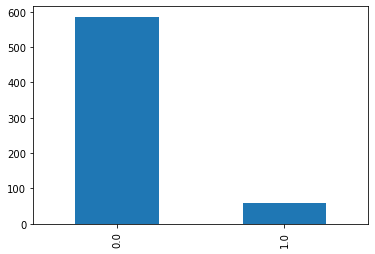

In [4]:

anos=[2005,2006]

df_T = pd.DataFrame()
_T = {}
for ano in anos:    
            caminho = base_path+"dou/"+str(ano)+"/"+str(ano)+".xlsx"
            
            df_1 = pd.read_excel(caminho)
            _T[caminho+'_1_0'] = df_1[df_1['target']==1]
            _T[caminho+'_0_0'] = df_1[df_1['target']==0]            
            
for key, value in _T.items():
    df_T = pd.concat([df_T,value])    
    
df_T.target.astype('int', copy=False)    

df_T.shape

df_original =  df_T
df_original =  df_T[df_original.texto.isnull()==False]
df_original =  df_original[df_original.tipo.apply(lambda x: isinstance(x, str) == True)]
for d in df_original['tipo']:
    if(isinstance(d, str)==False):
        print(isinstance(d, str))
df_original =  df_original.drop(columns=['Unnamed: 12'])
df_original.rename(columns = {"tipo":"_tipo"}, inplace = True)

os.chdir(base_path+'/dou')

print(df_original.shape)
print(df_original.target.value_counts())
df_original.target.value_counts().plot(kind='bar')
df_original.head()

print(df_original.target.value_counts()[1]/df_original.target.value_counts()[0])

df_original.to_pickle("dataframe_original_desbalanceado.pkl")

Balanceamento - Implementando Oversampling minoritário

(1166, 12)
0.0    586
1.0    580
Name: target, dtype: int64
0.9897610921501706


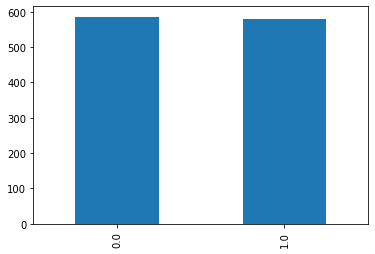

In [5]:

anos=[2005,2006]

df_T = pd.DataFrame()
_T = {}
for ano in anos:    
            caminho = base_path+"dou/"+str(ano)+"/"+str(ano)+".xlsx"
            #try:
            df_1 = pd.read_excel(caminho)
            _T[caminho+'_1_0'] = df_1[df_1['target']==1]
            _T[caminho+'_1_1'] = df_1[df_1['target']==1] 
            _T[caminho+'_1_2'] = df_1[df_1['target']==1]
            _T[caminho+'_1_3'] = df_1[df_1['target']==1]
            _T[caminho+'_1_4'] = df_1[df_1['target']==1]
            _T[caminho+'_1_5'] = df_1[df_1['target']==1]
            _T[caminho+'_1_6'] = df_1[df_1['target']==1]
            _T[caminho+'_1_7'] = df_1[df_1['target']==1]
            _T[caminho+'_1_8'] = df_1[df_1['target']==1]
            _T[caminho+'_1_9'] = df_1[df_1['target']==1]
            _T[caminho+'_0_0'] = df_1[df_1['target']==0]
            #except:
            
for key, value in _T.items():
    df_T = pd.concat([df_T,value])
    
    #print(caminho)
df_T.target.astype('int', copy=False) 
df_T.shape

df_original =  df_T
df_original =  df_T[df_original.texto.isnull()==False]
df_original =  df_original[df_original.tipo.apply(lambda x: isinstance(x, str) == True)]
for d in df_original['tipo']:
    if(isinstance(d, str)==False):
        print(isinstance(d, str))
df_original =  df_original.drop(columns=['Unnamed: 12'])
df_original.rename(columns = {"tipo":"_tipo"}, inplace = True)

df_original.shape
os.chdir(base_path+'/dou')

print(df_original.shape)
print(df_original.target.value_counts())
df_original.target.value_counts().plot(kind='bar')
df_original.head()
#print(df_original.isna().sum())
print(df_original.target.value_counts()[1]/df_original.target.value_counts()[0])

df_original.to_pickle("dataframe_original_balanceado.pkl")